<a href="https://colab.research.google.com/github/Clarke-Jools-36/Clarke-Jools-36/blob/main/jwst_pipeline_tutorial_stage_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will now run stage 2 of the pipeline.  This takes the rateints FITS files from the end of Stage 1 and ends with the production of 1D stellar spectra (one per integration) which are stored as FITS files.  


**First mount your drive** by clicking on the file icon on the left, and choose the third icon at the top to mount.  This will allow you to access the JWST_practical folder and the jwst_tutorial_output files from Stage 1.  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next we must again install the official JWST pipeline software package.
**This cell will run and end with an intentional error (run time will start again). Just ignore this and go to the next cell.**

In [ ]:
!pip install jwst
import os
os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.0/299.0 KB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.7/866.7 KB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.4/414.4 KB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 KB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━

We will again assign the environmental variables that allow the computer to know the weblink for obtaining reference files and where to store these files.  We will also import all the python packages we need for this stage.

In [1]:
import os

os.environ['CRDS_SERVER_URL']= 'https://jwst-crds.stsci.edu'
os.environ['CRDS_PATH'] = '/content/JWST_practical/crds_cache' 

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
# jwst pipeline packages
import jwst
from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
from jwst.background.background_step import BackgroundStep
from jwst.extract_2d.extract_2d_step import Extract2dStep
from jwst.srctype.srctype_step import SourceTypeStep
from jwst.wavecorr.wavecorr_step import WavecorrStep
from jwst.flatfield.flat_field_step import FlatFieldStep
from jwst.photom.photom_step import PhotomStep
from jwst.stpipe import Step 
from jwst import datamodels

output_dir = './drive/MyDrive/jwst_tutorial_output'
 

Let's have a look at what is inside a rateints file.  First print out all the extensions.

In [2]:
seg ='001'
hdul = fits.open('/content/drive/MyDrive/jwst_tutorial_output/WASP-39b_prism_seg_%s_rateints.fits'%(seg))
hdul.info()

Filename: /content/drive/MyDrive/jwst_tutorial_output/WASP-39b_prism_seg_001_rateints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     241   ()      
  1  SCI           1 ImageHDU        63   (512, 32, 61)   float32   
  2  ERR           1 ImageHDU        11   (512, 32, 61)   float32   
  3  DQ            1 ImageHDU        12   (512, 32, 61)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   61R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (512, 32, 61)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (512, 32, 61)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [8005B]   


The first extension is the 'header'.  It contains various important information about the observation.

In [3]:
for i in range (len(hdul[0].header)):
  print (hdul[0].header[i])

True
8
0
True
2023-03-10T14:30:44.086
STSCI
UTC
s
WASP-39b_prism_seg_001_rateints.fits
2022_2a
PRDOPSSOC-055
008.004.011.000
1.9.6
RELEASE
CubeModel
JWST
False
59770.49140304398
0.0
False

Program information

The Transiting Exoplanet Community Early Release Science Program
Batalha, Natalie
ERS
Planets and Planet Formation

Observation identifiers

2022-07-10
15:30:58.605
2022-07-10T15:30:58.605
2022-07-10T23:37:13.245
V01366004001P0000000004101
01366004001
01366
004
001
04
1
01
1
False
NIRSpec Bright Object Time Series
NIRSpec PRISM
Transmission - WASP-39b

Visit information

OK
CALCULATED_TRACK_TR_202111
PRIME_TARGETED_FIXED
2022-07-10 14:05:46.1740000
SUCCESSFUL
3
False
False
True
False
False

Target information

WASP-39
WASP-39
FIXED
217.3266479166666
-3.444500000000005
0.1
0.1
-0.01905299998720449
0.000345
2015-07-02 12:00:00.0000000
217.3266479166666
-3.4445
UNKNOWN

Instrument configuration information

NIRSPEC
NRS1
CLEAR
PRISM
S1600A1
3
PRIMARYPARK_ALLCLOSED
NONE
BRIGHTOBJ
0.33

Let's look at a single integration level image 
from the file, picked randomly.  Enter the correct extension number needed to see the science data (x)

In [4]:
#let x be the extention that holds the science data
x =  "SCI"
 

In [5]:
data = hdul[x].data
data.shape

(61, 32, 512)

Now we will pick a random integration and look at the integration image.  Remember the values in each pixel are now in units of e$^-$/sec (i.e. it is a count rate).

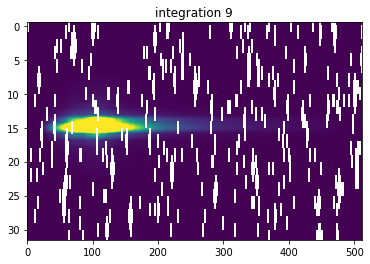

In [6]:
z = int(np.random.uniform(0,data.shape[0]-1))
img = data[z]
plt.figure('integration %s'%(z))
plt.title('integration %s'%(z))
plt.imshow(img, aspect='auto', vmin = 0, vmax = np.nanpercentile(img,99));

What are all the white pixels?  What value do they have?  Print out the first row of values.

In [7]:
print (img[0])

[ 1.40140009e+00             nan  8.67741466e-01 -1.17776203e+00
  4.21417356e-01 -3.58920932e+00 -1.36822611e-01 -1.42843449e+00
  1.96240032e+00  2.10016459e-01 -7.59356260e-01 -2.61063313e+00
  1.03710435e-01  1.00998782e-01 -1.69901359e+00 -2.56141281e+00
 -1.96258113e-01 -1.00445306e+00 -4.92545462e+00 -2.54957008e+00
  1.36260629e+00 -8.88939857e-01 -8.02341640e-01  2.00983143e+00
  4.14693356e+00 -2.76010871e+00  2.75246930e+00 -8.67435634e-01
 -1.03292480e-01 -8.02379370e-01 -3.59714675e+00  2.04628420e+00
 -2.18721747e+00 -9.21254396e-01 -7.90281868e+00 -5.07968760e+00
  7.45434761e-01 -6.72891617e+00 -2.02886033e+00 -2.47835070e-01
  1.21007271e-01 -7.15983570e-01 -2.35743508e-01 -1.06495810e+00
 -8.90169442e-02 -2.87441999e-01  6.60170197e-01  2.32730842e+00
 -5.72891712e-01  5.05742908e-01  9.32563245e-01  5.52594364e-01
 -8.78245607e-02  2.32165718e+00  2.24747062e+00  3.15623999e-01
 -6.59087038e+00 -3.83195639e+00 -3.16651845e+00  3.05829263e+00
  9.65463400e-01 -1.09316

Print out the corresponding row in the DQ array.  What do you notice?

In [8]:
DQ = hdul[3].data

In [9]:
print (DQ[z][0])

[         0   16777217          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0   16777217          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0          0
          0          0          0          0          0       

The non-zero flags are for 'bad pixels'.  These may be pixels that are intrinsically bad, and flagged as such, or could be due to saturation in the first group (no unstaurated groups), or a bad ramp that could not be fitted etc.  Each cause of bad pixels has a particular flag number.

https://jwst-reffiles.stsci.edu/source/data_quality.html

However a particular pixel may have more than one bad flag, in which case they are added up.
So a pixel with flags 1 and 4 is given a number 5 in the DQ array.  The code below can deconstruct the number to give the individual flags.  



In [10]:
def workout_dq_flags(x):
  aa= []
  for i in range(1000):
    bb = i+1
    if 2**bb > x:
      break
    aa.append(2**bb)
  for i in range(len(aa)-1,0,-1):
    if i == len(aa)-1:
      bb = x-aa[i]
      print (aa[i])
    else:
      if bb/aa[i] < 1:
        pass
      else:
        bb = bb-aa[i]
        print (aa[i])
    if bb == 2:
      print (2)
      break
    if bb == 1:
      print (1)
      break

 

Next pick a bad flag number you can see from the DQ array values you printed above and enter it into the function.  

In [12]:
#Enter the DG flag number
x = 1073741825
workout_dq_flags(x)

1073741824
1


Now look up what the flags mean: https://jwst-reffiles.stsci.edu/source/data_quality.html

Check out a few of these bad pixel flags to get an idea of why they have been flagged.

We have to correct these bad pixels otherwise we will not be able to construct a stellar spectrum for each integration which is the goal of stage 2.

----

We will now start stage 2.  We must create two custom steps.  These are another background subtraction step (but now implemented at the integration ramp level, not group level) and a bad pixel identification step, to find yet more bad pixels...

In [13]:
class CustomBkgStage2_prism(Step):
     
    class_alias = "custom_bkg"
    spec = """ """
    def process(self, input):
        with datamodels.CubeModel(input) as input_model:      
            result = self.custom_bkg_subtraction(input_model)
            input_model.close()
            result.meta.cal_step.custom_bkg = 'COMPLETE'
        return result
    
    def custom_bkg_subtraction(self, input_model):
        bm = input_model
        data = bm.data
        sup_img = np.nanmedian(data,axis=0)
        y_profile = np.sum(sup_img, axis=1)
        y_max = np.argmax(y_profile)
 
        mask = np.ones_like(sup_img)
        bbox=10
        mask[y_max-bbox: y_max+bbox+1] = np.nan
        sup_img_masked = (mask*sup_img)

        for intg in range(data.shape[0]):
            img = data[intg]
            bkg= img*1
            bkg = np.vstack((bkg[0:6], bkg[-6:]))
            bkg_std = np.nanstd(bkg,axis=0)
            bkg_std = np.tile(bkg_std, (bkg.shape[0], 1))
            bkg_mean = np.nanmean(bkg, axis=0)
            bkg_mean = np.tile(bkg_mean, (bkg.shape[0], 1))
            alpha = 3
            bkg = np.where(bkg> bkg_mean + bkg_std*alpha, np.nan, bkg) 
            bkg = np.where(bkg< bkg_mean - bkg_std*alpha, np.nan, bkg) 
            bkg = np.nanmean(bkg, axis =0)
            img_masked = img*mask
            bkg_median = np.nanmedian(img_masked, axis=0)
            img = img - bkg_median
            data[intg] = img
        bm.data = data   
        return bm


In [14]:
class CustomBadPixelIdentifier(Step):
     
    class_alias = "custom_bad_pixel"

    spec = """ """
    # reference_file_types = ['superbias']

    def process(self, input):

        # Open the input data model
        with datamodels.CubeModel(input) as input_model:      
            result = self.custom_bad_pixel_identifier(input_model)
            input_model.close()
            result.meta.cal_step.custom_bad_pixel_identifier = 'COMPLETE'
        return result
    
    def custom_bad_pixel_identifier(self, input_model):
        
        sci = input_model.data
        dq_ = input_model.dq
        # exclude pure saturation flags  and jumps from DQ
        # dq_ =  np.where(dq_==2, 0, dq_)
        dq_ = np.where(dq_ & 2 > 0, dq_ -2, dq_)
        dq_ = np.where(dq_ & 4 > 0, dq_-4, dq_)
 
        bad_flag = np.where(dq_==0,1,np.nan)
        sci *= bad_flag  # bad flag applies nans to bad pixel locations
        #plt.figure(34)
        #plt.imshow(sci[0], interpolation='None')
        
        for intg in range(sci.shape[0]):
            
            print ('bad pixel flagging for image %s.....'%(intg))
            img = sci[intg]
            dq = dq_[intg]
            '''
             find outliers in the image, based on rolling line median, line sigma and rolling local line sigma
            '''
            alpha =  5 #sigma clip level
            iter = 1 # number of iterations
            
            for ii in range(iter):
                bbox = 5 # rolling median of 5 pixels centred on the column i
                local_median = np.zeros((img.shape[0], img.shape[1]))
                local_std = np.zeros((img.shape[0], img.shape[1]))     
                for i in range(bbox, img.shape[1]- bbox):
                    slice = img[:,i-bbox:i+bbox+1]
                    slice = np.delete(slice, bbox, 1) 
                    local_median[:,i] = np.nanmedian(slice, axis=1)
                    local_std[:,i] = np.nanstd(slice, axis=1)
                # fill edge values with closest column values
                local_median[:,0:bbox] = np.tile(local_median[:,bbox],(bbox, 1)).T
                local_median[:,-bbox:None] = np.tile(local_median[:,-bbox-1],(bbox, 1)).T      
                local_std[:,0:bbox] = np.tile(local_std[:,bbox],(bbox, 1)).T
                local_std[:,-bbox:None] = np.tile(local_std[:,-bbox-1],(bbox, 1)).T        
                # find a line sigma based on the 16-84 pc range    
                line_pc16 = np.nanpercentile(img,16, axis=1) #  
                line_pc84 = np.nanpercentile(img,84, axis=1) #   
                line_sigma =    (line_pc84-line_pc16) /2
                line_sigma = np.tile(line_sigma, (img.shape[1] , 1)).T
                # now clip outliers and replace with nans : based on line sigma
                idx = np.argwhere(img > local_median + alpha*line_sigma).T
                for j in range(len(idx[0])):
                    img[idx[0][j]][idx[1][j]] = np.nan
                idx = np.argwhere(img < local_median - alpha*line_sigma).T
                for j in range(len(idx[0])):
                    img[idx[0][j]][idx[1][j]] = np.nan
                # clip again based on the local std
                idx = np.argwhere(img > local_median + alpha*local_std).T
                for j in range(len(idx[0])):
                    img[idx[0][j]][idx[1][j]] = np.nan
                idx = np.argwhere(img < local_median -  alpha*local_std).T
                for j in range(len(idx[0])):
                    img[idx[0][j]][idx[1][j]] = np.nan
            sci[intg] = img

        input_model.data = sci   
        return input_model


We will first combine all the rateints files from stage 1 into one big file.  This helps when we generate a median image later which we use to find and fill in outliers.  Otherwise the big file will have exactly the same structure as one of the smaller files.

In [15]:
seg_list = ['001', '002', '003', '004']
for seg in seg_list:
 
    rateints_file = '/content/drive/MyDrive/jwst_tutorial_output/WASP-39b_prism_seg_%s_rateints.fits'%(seg)
    hdul = hdul = fits.open(rateints_file)
    sci = hdul[1].data
    err = hdul[2].data
    dq = hdul[3].data 
    int_times = hdul[4].data  
    varp = hdul[5].data   
    varr = hdul[6].data  
    
    if seg == seg_list[0]:
        sci_stack = sci
        err_stack = err
        dq_stack = dq
        int_times_stack = int_times
        varp_stack = varp
        varr_stack = varr
 
    else:
        sci_stack = np.vstack((sci_stack, sci))
        err_stack = np.vstack((err_stack, err))
        dq_stack = np.vstack((dq_stack, dq))
        varp_stack = np.vstack((varp_stack, varp))
        varr_stack = np.vstack((varr_stack, varr))
        int_times_stack = np.hstack((int_times_stack, int_times))
   
    hdul.close()

# pick first file as the template 
# rateints_file = '/Users/user1/Downloads/JWST webinars/NIRSpec_grating/fits_files/%s_%s_run_1_rateints.fits'%(nrs,seg_list[0])
hdul = hdul = fits.open(rateints_file)

header = hdul[0].header
header['EXSEGNUM'] = 1
header['EXSEGTOT'] = 1
header['INTSTART'] =  1
header['INTEND'] = header['NINTS'] # assuming all the files have the same total nints in the header
hdul[0].header = header

hdul[1].data =  sci_stack
hdul[2].data =  err_stack
hdul[3].data =  dq_stack
hdul[4].data =  int_times_stack
hdul[5].data =  varp_stack
hdul[6].data =  varr_stack
 

outfile0  = rateints_file
outfile0  = outfile0.replace('004', 'COMBINED')
# # Write the new HDU structure to outfile
hdul.writeto(outfile0, overwrite=True)

hdul.close()

rateints_file = outfile0


We will run the first part of stage 2.  We use the official pipeline step 'AssignWCS' to again convert the FITS file data into a datamodel.  The step does not change the science data.

Then we implement a second background subtraction step.  

And then we perform a bad pixel identification step.  You may wonder why we do this as we have plenty of bad pixels already.  We need to take account of pixel values that may not have triggered a bad flag.  An example might be a cosmic ray hit.  This step just assigns nan values to any outliers.  It doesn't correct the pixels.

In [16]:
# =============================================================================
# now run pipeline on combined file 
# =============================================================================
result = rateints_file

step = AssignWcsStep()
step.save_results = False
result = step.run(result)
 
step = CustomBkgStage2_prism()
step.save_results = False
result = step.run(result)  

step = CustomBadPixelIdentifier()
step.save_results = False
result = step.run(result)



2023-03-10 14:46:23,128 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
INFO:stpipe.AssignWcsStep:AssignWcsStep instance created.
2023-03-10 14:46:23,405 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('/content/drive/MyDrive/jwst_tutorial_output/WASP-39b_prism_seg_COMBINED_rateints.fits',).
INFO:stpipe.AssignWcsStep:Step AssignWcsStep running with args ('/content/drive/MyDrive/jwst_tutorial_output/WASP-39b_prism_seg_COMBINED_rateints.fits',).
2023-03-10 14:46:23,415 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_hig

bad pixel flagging for image 0.....
bad pixel flagging for image 1.....
bad pixel flagging for image 2.....
bad pixel flagging for image 3.....
bad pixel flagging for image 4.....
bad pixel flagging for image 5.....
bad pixel flagging for image 6.....
bad pixel flagging for image 7.....
bad pixel flagging for image 8.....
bad pixel flagging for image 9.....
bad pixel flagging for image 10.....
bad pixel flagging for image 11.....
bad pixel flagging for image 12.....
bad pixel flagging for image 13.....
bad pixel flagging for image 14.....
bad pixel flagging for image 15.....
bad pixel flagging for image 16.....
bad pixel flagging for image 17.....
bad pixel flagging for image 18.....
bad pixel flagging for image 19.....
bad pixel flagging for image 20.....
bad pixel flagging for image 21.....
bad pixel flagging for image 22.....
bad pixel flagging for image 23.....
bad pixel flagging for image 24.....
bad pixel flagging for image 25.....
bad pixel flagging for image 26.....
bad pixel f

2023-03-10 14:48:45,929 - stpipe.CustomBadPixelIdentifier - INFO - Step CustomBadPixelIdentifier done
INFO:stpipe.CustomBadPixelIdentifier:Step CustomBadPixelIdentifier done


We next run these 4 steps.  Look up what each of these steps do: 

https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_2d.Extract2dStep.html

https://jwst-pipeline.readthedocs.io/en/latest/jwst/srctype/index.html

https://jwst-pipeline.readthedocs.io/en/latest/jwst/wavecorr/index.html

https://jwst-pipeline.readthedocs.io/en/latest/jwst/photom/index.html

Note we are omitting flat fielding.  This is because the JWST flat field reference files are not accurate at this time.

We place the results after the Photom step into a FITS file.

In [17]:
step = Extract2dStep()
step.save_results = False
result = step.run(result)

step = SourceTypeStep()
step.save_results = False
result = step.run(result)

step = WavecorrStep()
step.save_results = False
result = step.run(result)

#step = FlatFieldStep()
#step.save_results = True
#result = step.run(result)

step = PhotomStep()
step.save_results = False
result = step.run(result)

filename = rateints_file.replace('rateints', 'photom')
result.save(filename)   
 

2023-03-10 14:49:46,507 - stpipe.Extract2dStep - INFO - Extract2dStep instance created.
INFO:stpipe.Extract2dStep:Extract2dStep instance created.
2023-03-10 14:49:46,687 - stpipe.Extract2dStep - INFO - Step Extract2dStep running with args (<CubeModel(215, 32, 512) from WASP-39b_prism_seg_COMBINED_rateints.fits>,).
INFO:stpipe.Extract2dStep:Step Extract2dStep running with args (<CubeModel(215, 32, 512) from WASP-39b_prism_seg_COMBINED_rateints.fits>,).
2023-03-10 14:49:46,694 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'grism_objects': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'wfss_mmag_extract': None, 'wfss_nbright': 1000}
INFO:stpipe.Extract2dSt

'/content/drive/MyDrive/jwst_tutorial_output/WASP-39b_prism_seg_COMBINED_photom.fits'

The output from the Photom step is saved a FITS file. Let's read in this file ready for the next steps, and have a look at its contents.

In [18]:
stage_2a_file = '/content/drive/MyDrive/jwst_tutorial_output/WASP-39b_prism_seg_COMBINED_photom.fits' 
hdul =  fits.open(stage_2a_file)
hdul.info()

Filename: /content/drive/MyDrive/jwst_tutorial_output/WASP-39b_prism_seg_COMBINED_photom.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     317   ()      
  1  SCI           1 ImageHDU        85   (432, 22, 215)   float32   
  2  ERR           1 ImageHDU        11   (432, 22, 215)   float32   
  3  DQ            1 ImageHDU        12   (432, 22, 215)   int32 (rescales to uint32)   
  4  WAVELENGTH    1 ImageHDU         9   (432, 22)   float32   
  5  AREA          1 ImageHDU        10   (432, 22, 215)   float32   
  6  VAR_POISSON    1 ImageHDU        10   (432, 22, 215)   float32   
  7  VAR_RNOISE    1 ImageHDU        10   (432, 22, 215)   float32   
  8  VAR_FLAT      1 ImageHDU        10   (432, 22, 215)   float32   
  9  INT_TIMES     1 BinTableHDU     24   215R x 7C   [J, D, D, D, D, D, D]   
 10  ASDF          1 BinTableHDU     11   1R x 1C   [115788B]   


What do you notice about the size of the science array compared to before?  What extensions have been added that weren't there before?

Okay... let's have a look at one of the images after all these steps.  We will look at the first integration image. What do you notice?

(215, 22, 432)


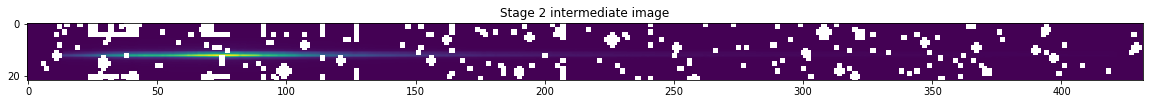

In [19]:
data = hdul[1].data
print (data.shape)
plt.figure('Stage 2 intermediate image', figsize=(20,40))
plt.title('Stage 2 intermediate image')
plt.imshow(data[0]);

We have many patches of 'bad' pixels.  Basically we have tried to capture as many bad pixel values as possible - you can see there are quite a few.   We will now attempt to fill these values in.   

This is done using a combination of using interpolated values in both pixel light curves and image row profiles to fill in nan values.

A median image is also used to find outliers and fill in values.

The science data will be temporarily held in an array called sci_stack while we make these corrections.

In [20]:
# =============================================================================
# fill in nans
# =============================================================================
# first try to fill via light curve ( if < 10% missing)
 
sci_stack = hdul[1].data
sci_stack_pre = hdul[1].data*1
x = np.arange(sci_stack.shape[0])
for i in range(sci_stack.shape[2]):
    for j in range(sci_stack.shape[1]):
        lc = sci_stack[:, j,i]
        # plt.figure('lc')
        idx = np.argwhere(np.isnan(lc)).T[0]
        if len(idx) >0 and len(idx) < 0.1*len(x):
        # if len(idx) >0 and len(idx) < len(x):
            x_new = np.delete(x,idx)
            lc_new = np.delete(lc,idx)
            lc_filled = np.interp(x, x_new, lc_new)
            # plt.plot(lc_filled, 'ro-')
            # plt.plot(lc, 'bo-')
            sci_stack[:, j,i] = lc_filled
        # if more than 10% missing then treat whole timeline as bad and make nan 
        if len(idx) >0 and len(idx) >= 0.1*len(x) and len(idx)!= len(x):
            sci_stack[:, j,i] = np.nan
            
# now deal with remaining nans including all the way through: have to filled spatially.
x = np.arange(sci_stack.shape[2])
for k in range(sci_stack.shape[0]):
    for i in range(sci_stack.shape[1]):
    
        row = sci_stack[k][i]
        row0 = row*1
        
        idx = np.argwhere(np.isnan(row)).T[0]
        if len(idx)>0:
            x_new = np.delete(x,idx)
            row_new = np.delete(row, idx)
            row_filled = np.interp(x, x_new, row_new)
            # plt.plot(row_filled, 'ro-')
            # plt.plot(row, 'bo-')
            sci_stack[k][i] = row_filled
            # plt.figure()
            # plt.plot(row_filled, 'ro-')
            # plt.plot(row0, 'bo')
  
print ('done')

# =============================================================================
# make a median stack if needed for comparison and replacement : use at this point so that medians exist for any spatially filled points (e.g. if nan all the way through)
# =============================================================================
 
median_stack = np.zeros_like(sci_stack)
std_stack = np.zeros_like(sci_stack)
alpha =3
box = 10
 
for i in range(sci_stack.shape[0]):
    #print(i)
    if i <box:
        box_l = i
        box_r = box + 1
    if i + box+1 > sci_stack.shape[0]-1:
        box_l = box
        box_r = box
    median_stack[i] = np.nanmedian(sci_stack[i-box_l:i+box_r], axis=0)
    std_stack[i] = np.nanstd(sci_stack[i-box_l:i+box_r], axis=0)
median_std = np.nanmedian(std_stack, axis =0)
  
# =============================================================================
# Light curve pixel level outliers - correction : we use a median to both detect outlier and apply correction
# =============================================================================
 
sci_stack = np.where(sci_stack>median_stack+alpha*std_stack, median_stack, sci_stack)
sci_stack = np.where(sci_stack<median_stack-alpha*std_stack, median_stack, sci_stack)

sci_stack = np.where(sci_stack>median_stack+alpha*median_std, median_stack, sci_stack)
sci_stack = np.where(sci_stack<median_stack-alpha*median_std, median_stack, sci_stack)
    
 


done


In [21]:
sci_stack.shape

(215, 22, 432)

Let's look at the same image as before and after correction.  We will pick a random integration.  You can repeatedly run this cell to pick different random integrations.

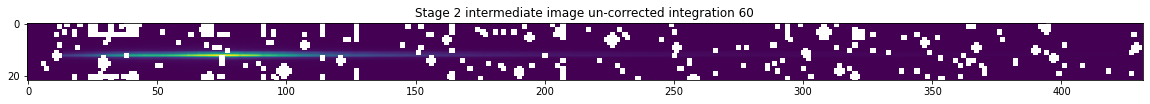

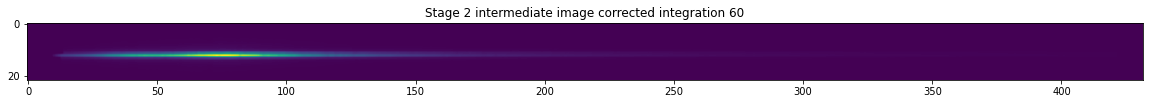

In [26]:
intg = int(np.random.uniform(0,sci_stack.shape[0]-1))
plt.figure('Stage 2 intermediate image un-corrected', figsize=(20,40))
plt.title('Stage 2 intermediate image un-corrected integration %s'%(intg))
plt.imshow(sci_stack_pre[intg], vmin =0, vmax=sci_stack[intg].max());
plt.figure('Stage 2 intermediate image corrected', figsize=(20,40))
plt.title('Stage 2 intermediate image corrected integration %s'%(intg))
plt.imshow(sci_stack[intg],vmin =0, vmax=sci_stack[intg].max());

The dimensions of the image array are given above.  The first dimension is the number of integrations.  The second is the number of x pixels, and the third is the number of y pixels.  

We must now take the image stack and sum it in the y direction to get a 1-D stellar spectrum for each integration (we change the 3-D array into a 2-D array)

**I would like you to do this below.** Fill in the blanks in the code.  Call the new 2-D array spectra_stack.  What do you expect the dimensions of spectra_stack to be?

In [27]:
# start with the 3-D array
data = sci_stack
spectra_stack = np.sum(data, axis = 1)
print (spectra_stack.shape)


(215, 432)


Let's look at a random spectrum from the stack.

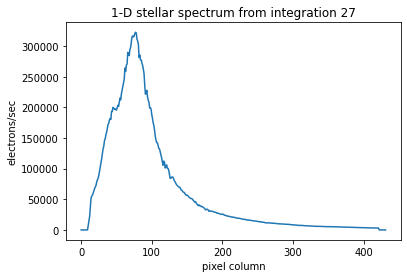

In [28]:
intg = int(np.random.uniform(0,spectra_stack.shape[0]-1))
plt.figure('1-D stellar spectrum from integration %s'%(intg))
plt.title('1-D stellar spectrum from integration %s'%(intg))
plt.ylabel('electrons/sec')
plt.xlabel('pixel column')
plt.plot(spectra_stack[intg]);


We can actually assign wavelengths to the pixel columns: note they were added during the earlier Stage 2 steps.  The wavelengths vary very slightly in the y direction, so we will take an average per pixel column.  We will plot the same spectrum with wavelength on the x-axis.  Is this the wavelength range we expect for NIRSpec Prism?  What about the shape of the stellar spectrum... is this what you expect?

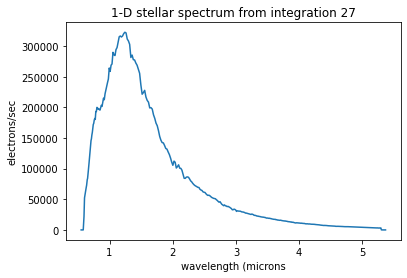

In [29]:
wl_grid = np.nanmean(hdul[4].data, axis=0)
plt.figure('1-D stellar spectrum from integration %s'%(intg))
plt.title('1-D stellar spectrum from integration %s'%(intg))
plt.ylabel('electrons/sec')
plt.xlabel('wavelength (microns')
plt.plot(wl_grid, spectra_stack[intg]);


We also need to know the time of each integration to produce light curves.


In [30]:
int_times =  hdul[9].data

We will now package everything into final FITS file ready for the next stage.  This file will be stored in the jwst_tutorial_output folder ready for Stage 3.

In [31]:
n = np.arange(100.0)
hdu= fits.PrimaryHDU(n)
hdul = fits.HDUList([hdu])
table_hdu  = fits.BinTableHDU(data=int_times)
hdul.append(table_hdu)
hdul[1].header['EXTNAME']= 'INT_TIMES'

hdul.append(fits.ImageHDU(np.ones(10)))
hdul[2].header['EXTNAME']= 'SPEC'
hdul[2].data= spectra_stack

hdul.append(fits.ImageHDU(np.ones(10)))
hdul[3].header['EXTNAME']= 'WAV'
hdul[3].data= wl_grid

filename = stage_2a_file.replace('photom', '1Dspec')
hdul.writeto(filename, overwrite=True)
 

We now have a stack of stellar spectra with wavelength and time information.
We have everything we need to start stage 3. 